# ReadMe

# Environment Set Up

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
pd.options.display.float_format = "{:,.2f}".format

# Load Data

In [2]:
df=pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Notebook Start

## 1. Data Cleaning and EDA

### A. Cleaning and Quick Look

In [3]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,"7,043.00","7,043.00","7,043.00"
mean,0.16,32.37,64.76
std,0.37,24.56,30.09
min,0.00,0.00,18.25
25%,0.00,9.00,35.50
50%,0.00,29.00,70.35
75%,0.00,55.00,89.85
max,1.00,72.00,118.75


In [6]:
# Get object column unique value, Limit for <10 unique values
object_cols=[col for col in df.columns if df[col].dtype == 'object']
for i in object_cols:
    if len(df[i].unique())<=10:
        print(i, ":", df[i].unique())
    else:
        print(i, " has too many unique values of " + str(len(df[i].unique())) )

customerID  has too many unique values of 7043
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges  has too many unique values of 6531
Churn : ['No' 'Yes']


In [7]:
#Fix:
#1. Total Charges should be numeric, replace empty string with 0 and make it float
df['TotalCharges']=pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)


### B. EDA

In [8]:
def aggregate_dist(df=df, group_var='Churn',agg_var='TotalCharges',aggregation='sum', with_pct='Yes',viz_agg='Absolute'):

    df_temp=df.copy()
    df_agg=df_temp.groupby([group_var]).agg({agg_var:aggregation}).reset_index()
    df_agg=df_agg.rename(columns={agg_var:aggregation+' '+agg_var})

    if with_pct=='Yes':
        df_agg[aggregation+' '+agg_var+' Pct']=(df_agg[aggregation+' '+agg_var]/df_agg[aggregation+' '+agg_var].sum())*100
    else:
        pass

    display(df_agg)
    
    if viz_agg=='Absolute':
        y_var=aggregation+' '+agg_var
    elif viz_agg=='Percentage':
        y_var=aggregation+' '+agg_var+' Pct'
    else:
        raise ValueError('Wrong Input')
    
    sns.barplot(data=df_agg,x=group_var,y=y_var)

    sns.despine()
    plt.show()
    return df_agg
        

In [9]:
def tabulation(df=df, row_var='Churn', col_var='MultipleLines',
               val_var='customerID', aggregation='nunique', with_pct='Yes'):

    df_agg = df.groupby([row_var, col_var]).agg({val_var: aggregation}).reset_index()
    df_agg = df_agg.sort_values([row_var, col_var])


    df_pivot = pd.pivot_table(df_agg, index=row_var, columns=col_var, values=val_var, fill_value=0)

    if with_pct == 'Yes':
        grand_total = df_pivot.values.sum()
        df_pivot = df_pivot / grand_total * 100

    plt.figure(figsize=(6, 4))
    sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="Blues")
    if with_pct == 'Yes':
        plt.title(f"{val_var} Percentage Distribution by {row_var} and {col_var}", fontsize=12)
    else:
        plt.title(f"{val_var} Count Distribution by {row_var} and {col_var}", fontsize=12)
    plt.xlabel(col_var)
    plt.ylabel(row_var)
    plt.tight_layout()
    plt.show()


,Churn,nunique customerID,nunique customerID Pct
0,No,5174,73.46
1,Yes,1869,26.54


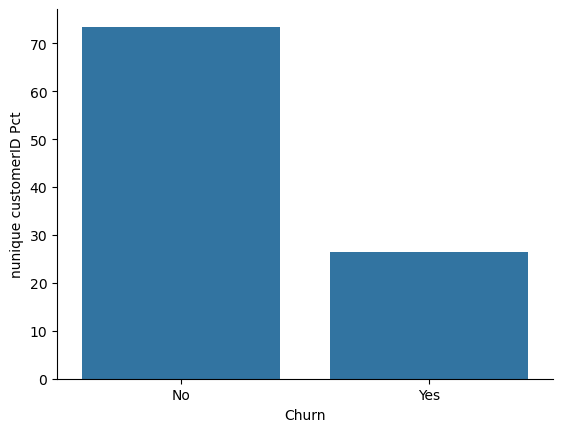

In [10]:
df_agg_status=aggregate_dist(df=df, group_var='Churn',agg_var='customerID',aggregation='nunique', with_pct='Yes',viz_agg='Percentage')

,Churn,mean MonthlyCharges
0,No,61.27
1,Yes,74.44


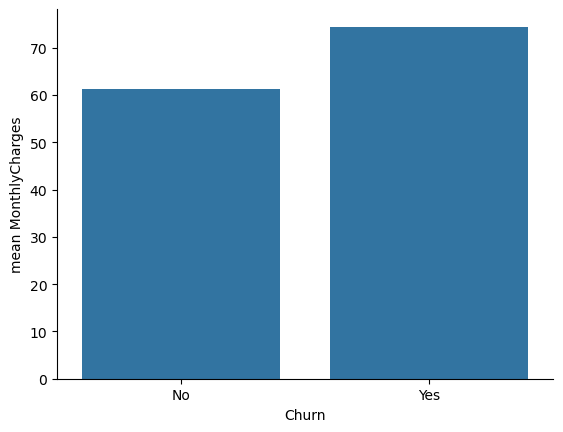

In [11]:
df_agg_revenue=aggregate_dist(df=df, group_var='Churn',agg_var='MonthlyCharges',aggregation='mean', with_pct='No',viz_agg='Absolute')

,Churn,sum TotalCharges,sum TotalCharges Pct
0,No,"13,193,241.80",82.17
1,Yes,"2,862,926.90",17.83


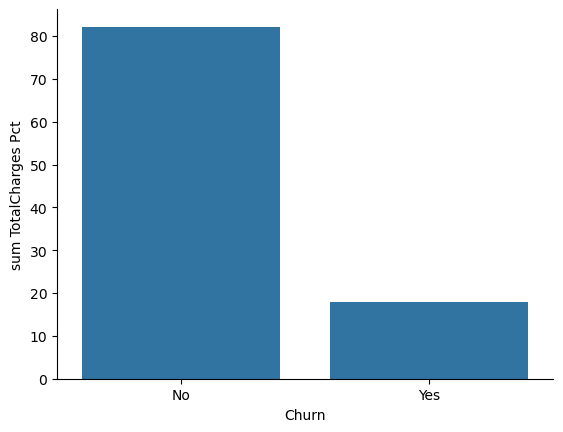

In [12]:
df_average_monthly_charge=aggregate_dist(df=df, group_var='Churn',agg_var='TotalCharges',aggregation='sum', with_pct='Yes',viz_agg='Percentage')

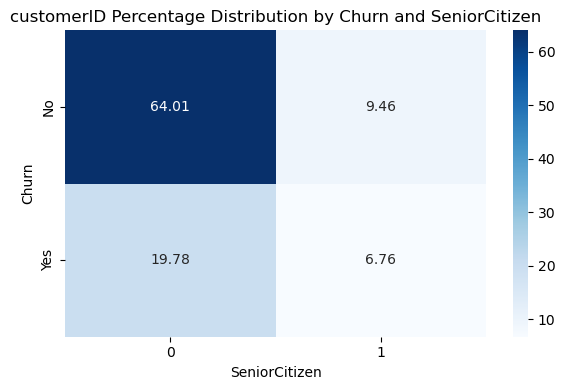

In [13]:
tabulation(df=df, row_var='Churn', col_var='SeniorCitizen', val_var='customerID',aggregation='nunique', with_pct='Yes')

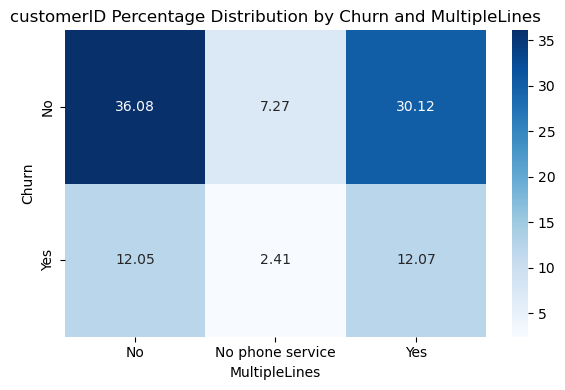

In [14]:
tabulation(df=df, row_var='Churn', col_var='MultipleLines', val_var='customerID',aggregation='nunique', with_pct='Yes')

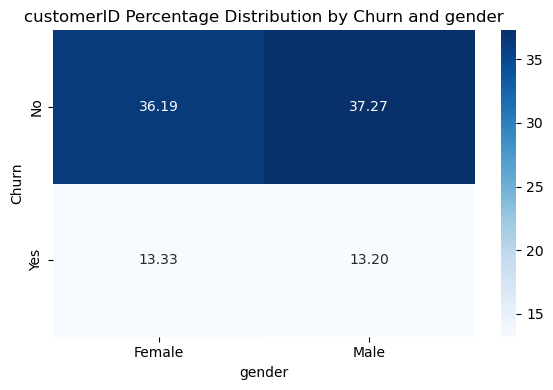

In [15]:
tabulation(df=df, row_var='Churn', col_var='gender', val_var='customerID',aggregation='nunique', with_pct='Yes')

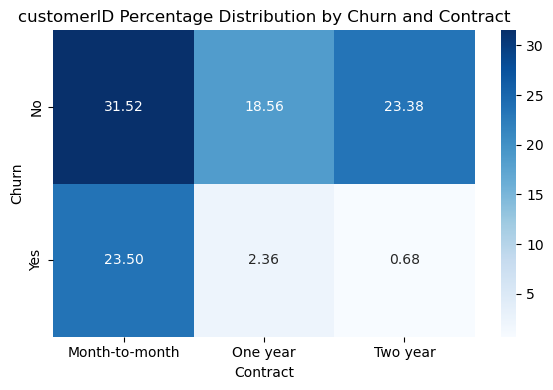

In [16]:
tabulation(df=df, row_var='Churn', col_var='Contract', val_var='customerID',aggregation='nunique', with_pct='Yes')

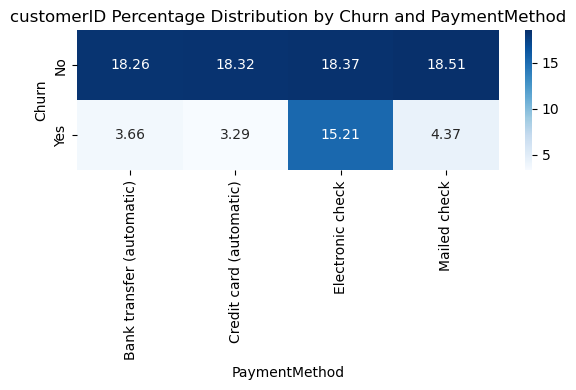

In [17]:
tabulation(df=df, row_var='Churn', col_var='PaymentMethod', val_var='customerID',aggregation='nunique', with_pct='Yes')

## Insights from EDA
- 26% of total customers churn, which constitute 18% of total charges/revenue, a big portion of revenue to be lost
- On average, churned customers have higher monthly charges compared to non churn. Losing high charge customers is hurting the company
- Among churn customers, the distribution is higher in:
    - Non senior citizen
    - Month to month contract user
    - Electronic check user
- Further analysis is needed to understand and prevent churn, hence the need for predictive model

## 2. Feature Selection and Cleaning
- Almost all columns are relevant in predicting churn, no feature leakage since all should be available during prediction
- Simple validation of correlation matrix is conducted among numeric columns

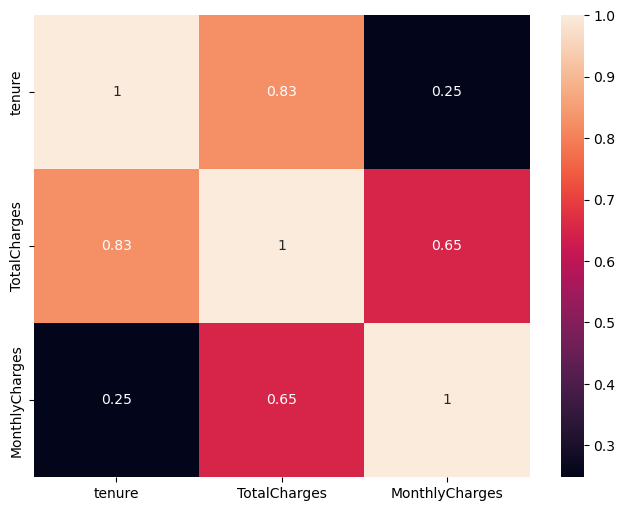

In [18]:
#Plot Correlation to avoid perfect multicollinearity in X, excluding dummy variables
corr_matrix=(df[['tenure','TotalCharges','MonthlyCharges']]).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [19]:
#No perfect correlation, move to Encode Dummy

categorical_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Y to binary
df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})
df_encoded=df_encoded.set_index('customerID') # retain the ID by making it index
df_encoded.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
5575-GNVDE,0,34,56.95,"1,889.50",0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
3668-QPYBK,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
7795-CFOCW,0,45,42.30,"1,840.75",0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
9237-HQITU,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


## 3. Predictive Modeling - Logistic Regression

Logistic Regression is chosen due to:
1. Churn category is binary, which is the native of logistic regression
2. Produce the likelihood of churn, customer can be categorized by their probability to churn
3. Easy to interpret and communicate to stakeholders
4. Low computational power and efficiency

### a. Preprocessing

In [20]:
#Split X and Y
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Resample Data with SMOTE due to Imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#standardize numerical Column
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X_train_res[num_cols] = scaler.fit_transform(X_train_res[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


### b. Running The Model

In [21]:
#Train Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_res, y_train_res)

#Test Model
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

In [22]:
# Get Feature Importance

feature_importance = pd.DataFrame({
    'Feature': X_train_res.columns,
    'Coefficient': log_reg.coef_[0],
}).sort_values(by='Coefficient', ascending=False)

feature_importance

,Feature,Coefficient
7,PhoneService_Yes,6.49
10,InternetService_Fiber optic,6.32
8,MultipleLines_No phone service,2.83
23,StreamingMovies_Yes,2.42
21,StreamingTV_Yes,2.30
9,MultipleLines_Yes,1.46
28,PaymentMethod_Electronic check,1.25
3,TotalCharges,1.20
17,DeviceProtection_Yes,1.13
15,OnlineBackup_Yes,1.00


Accuracy: 0.7920511000709723

Classification Report:
              precision    recall  f1-score   support

           0      0.882     0.828     0.854      1036
           1      0.592     0.692     0.638       373

    accuracy                          0.792      1409
   macro avg      0.737     0.760     0.746      1409
weighted avg      0.805     0.792     0.797      1409



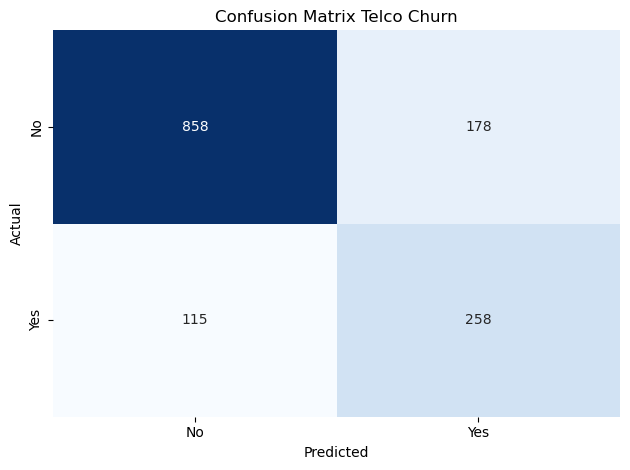


ROC-AUC Score: 0.8435866448601034


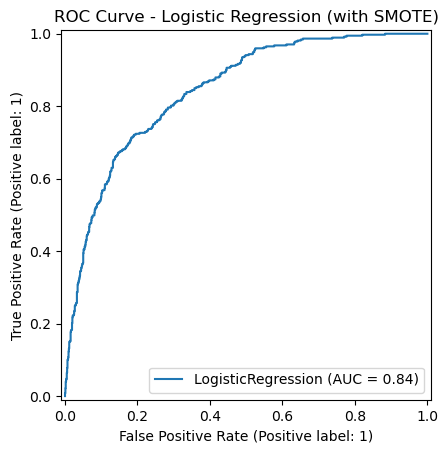

In [23]:
## Add Evaluation Metrics

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

#  Confusion Matrix
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix Telco Churn')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc}")

# ROC Curve
RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression (with SMOTE)")
plt.show()

## 4. Model Interpretation and Evaluation

**Logistic Model Interpretation**
- Customer who use PhoneService and Fiber Optic internet are the most likely to churn, given highest positive coefficient. Further and non quantitative investigation why such thing happens are recommended
- High monthly charge and longer tenures reduce probability of churn, customer engagement to retain customers are recommended
- Users with many services attached such as movie, streaming, and online security are more likely to churn, which also align with their total charges. Recommended to be cautious in cross-sell policy
**Logistic Model Evaluation**
- Accuracy of 79% is serviceable in churn prediction
- The precision and recall for retained customers are high at 88% and 82%, however the values are lower at 59% and 69% for churn customers
- Area under ROC curve shows 84%, which means  the model has strong discrimination power between churn and non churn

## 5 Additional File: Probability Churn per Customers (Test Data Only)

In [24]:
y_pred_class = log_reg.predict(X_test)

results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_class,
    'Predicted_Prob': y_pred_prob
}).reset_index()

results.head(10)


,customerID,Actual,Predicted,Predicted_Prob
0,1024-GUALD,1,1,0.85
1,0484-JPBRU,0,0,0.04
2,3620-EHIMZ,0,0,0.01
3,6910-HADCM,1,1,0.59
4,8587-XYZSF,0,0,0.00
5,6818-WOBHJ,1,0,0.14
6,3082-YVEKW,0,0,0.05
7,4737-AQCPU,0,0,0.01
8,4853-RULSV,1,0,0.18
9,5766-ZJYBB,1,0,0.42


In [25]:
def risk_level(p):
    if p >= 0.7:
        return 'High'
    elif p >= 0.4:
        return 'Medium'
    else:
        return 'Low'

results['Risk_Level'] = results['Predicted_Prob'].apply(risk_level)
results.head(10)


,customerID,Actual,Predicted,Predicted_Prob,Risk_Level
0,1024-GUALD,1,1,0.85,High
1,0484-JPBRU,0,0,0.04,Low
2,3620-EHIMZ,0,0,0.01,Low
3,6910-HADCM,1,1,0.59,Medium
4,8587-XYZSF,0,0,0.00,Low
5,6818-WOBHJ,1,0,0.14,Low
6,3082-YVEKW,0,0,0.05,Low
7,4737-AQCPU,0,0,0.01,Low
8,4853-RULSV,1,0,0.18,Low
9,5766-ZJYBB,1,0,0.42,Medium


In [26]:
results.to_csv('probability_of_churn_per_customer.csv')

## Notebook End